## 1. Import & 전처리

In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

In [9]:
Covid = pd.read_csv("./[코로나] tocken.csv", encoding='utf-8-sig')
Covid.head()

,Unnamed: 0,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,법률안,제안정당,법률공포여부,텍스트,토큰,명사수
0,0,2024549,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,2020-01-28,2020-02-26 00:00:00,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,최근 신종 코로나바이러스감염증(2019 novel Coronavirus 2019 ...,보건복지위원회,"[""['유의동(새로운보수당/兪義東)'"", "" '권성동(자유한국당/權性東)'"", "" ...",1.0,"['미래를향한전진4.0', '자유한국당', '바른미래당', '새로운보수당']",미공포,감염병의 예방 및 관리에 관한 법률 일부개정법률안 최근 신종 코로나바이러스감염증...,"['감염병', '예방', '관리', '법률', '일부개정법률안', '신종', '코로...",59
1,1,2024556,처,검역법 일부개정법률안,의원,2020-01-29,2020-05-29 00:00:00,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제375회,현행법은 보건복지부장관이 출입국의 금지 또는 정지 요청 규정상 검역감염병 환자등 또...,보건복지위원회,"[""['원유철(자유한국당/元裕哲)'"", "" '강석호(자유한국당/姜碩鎬)'"", "" '...",1.0,"['새로운보수당', '무소속', '자유한국당']",미공포,검역법 일부개정법률안 현행법은 보건복지부장관이 출입국의 금지 또는 정지 요청 규...,"['검역법', '일부개정법률안', '현행법', '보건복지부장관', '출입국', '금...",74
2,2,2024555,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,2020-01-29,2020-02-26 00:00:00,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,현행법은 감염병환자등이 발생하였거나 발생할 우려가 있는 경우 육군ㆍ해군ㆍ공군 소속 ...,보건복지위원회,"[""['원유철(자유한국당/元裕哲)'"", "" '강석호(자유한국당/姜碩鎬)'"", "" '...",1.0,"['새로운보수당', '무소속', '자유한국당']",미공포,감염병의 예방 및 관리에 관한 법률 일부개정법률안 현행법은 감염병환자등이 발생하...,"['감염병', '예방', '관리', '법률', '일부개정법률안', '현행법', '감...",59
3,3,2024582,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,2020-02-06,2020-02-26 00:00:00,대안반영폐기,NaN,의안원문\n비용추계서 미첨부 사유서,제20대 (2016~2020) 제375회,세계적으로 신종감염병의 수가 지난 60년간 4배 이상 늘어나면서 감염병 유행이 전 ...,보건복지위원회,"[""['기동민(더불어민주당/奇東旻)'"", "" '강훈식(더불어민주당/姜勳植)'"", ""...",1.0,['더불어민주당'],미공포,감염병의 예방 및 관리에 관한 법률 일부개정법률안 세계적으로 신종감염병의 수가 ...,"['감염병', '예방', '관리', '법률', '일부개정법률안', '세계적', '신...",142
4,4,2024584,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,2020-02-06,2020-02-26 00:00:00,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,최근 신종 코로나바이러스 감염병과 관련하여 의료기관은 중국 입국자 및 접촉자 관련 ...,보건복지위원회,"[""['허윤정(더불어민주당/許允貞)'"", "" '기동민(더불어민주당/奇東旻)'"", ""...",1.0,"['더불어민주당', '무소속']",미공포,감염병의 예방 및 관리에 관한 법률 일부개정법률안 최근 신종 코로나바이러스 감염...,"['감염병', '예방', '관리', '법률', '일부개정법률안', '신종', '코로...",91


In [10]:
# 명사 수가 50개를 넘어가는 경우만 추출

covid = Covid[Covid['명사수'] >= 50]
covid = covid.reset_index(drop=True)

# ['토큰'] 칼럼 콤마 기준 스플릿
for i in range(len(covid)):

    covid_tocken=[]

    covid['토큰'][i] = covid['토큰'][i][1:-1].split(', ')
    for j in covid['토큰'][i]:
        covid_tocken.append(j[1:-1])

    covid['토큰'][i] = covid_tocken

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [11]:
covid['토큰']

0      [감염병, 예방, 관리, 법률, 일부개정법률안, 신종, 코로나바이러스감염증, 국내,...
1      [검역법, 일부개정법률안, 현행법, 보건복지부장관, 출입국, 금지, 정지, 요청, ...
2      [감염병, 예방, 관리, 법률, 일부개정법률안, 현행법, 감염병환자, 발생, 발생,...
3      [감염병, 예방, 관리, 법률, 일부개정법률안, 세계적, 신종감염병, 이상, 감염병...
4      [감염병, 예방, 관리, 법률, 일부개정법률안, 신종, 코로나바이러스, 감염병, 관...
                             ...                        
384    [감염병, 예방, 관리, 법률, 일부개정법률안, 코로나, 감염병, 사회적, 경계, ...
385    [폐기물관리법, 일부개정법률안, 시행, 현행법, 급증, 의료폐기물, 원활한, 처리,...
386    [소상공, 보호, 지원, 법률, 일부개정법률안, 현행법, 소상공인, 자유로운, 기업...
387    [전기사업법, 일부개정법률안, 사태, 무역전쟁, 전세계적, 경제, 국면, 지역, 산...
388    [감염병, 예방, 관리, 법률, 일부개정법률안, 현행법, 제조제호, 보건복지부장관,...
Name: 토큰, Length: 389, dtype: object

#### 의미없는 단어 제거

In [12]:
def remove_stopword(text): 
    stopwords = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근',
                '집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', 
                 '명시', '촉진', '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해', '제조','제항', '일부개정법률안','조제항',
                 '제조의제항','관련','만원','천만원','억원','연장함','해당','제조제항제호','법률','신설','이하','시행','사항','제호','포함','코로나바이러스감염증','일부개정법률안의안번호',
                 '비롯','곳곳','허영','코로나']
    text = [word for word in text if word not in stopwords]
    return text

In [13]:
covid['토큰'] = remove_stopword(covid['토큰'])

## 2. 벡터화 - Word2Vec

#### 모델생성

In [14]:
#포스태깅된 컨텐츠를 300차원의 벡터로 바꿔라. 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(covid['토큰'], size=300, window = 10, min_count=50, workers=4, iter=100, sg=1)

In [15]:
# 기존 학습 모델
#model = gensim.models.Word2Vec.load('./ko/ko.bin')

#### 문장벡터 생성

In [16]:
def get_sentence_mean_vector(morphs):

    vector = []

    for i in morphs:

        try:
            vector.append(model.wv[i])
        except:
            pass


    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
    
    
covid['문장벡터'] = covid['토큰'].map(get_sentence_mean_vector)


In [17]:
covid['문장벡터'][0]

array([ 0.03771923,  0.03217825,  0.18394935, -0.00904461,  0.00148775,
       -0.0161849 , -0.05400394,  0.03698995,  0.17970158,  0.22600205,
        0.03727503, -0.0380431 ,  0.10958488,  0.00551861,  0.04556789,
       -0.15462668,  0.04934594,  0.01955394, -0.01419952, -0.08244588,
       -0.22043674, -0.0638486 ,  0.02008538, -0.26478466, -0.12490218,
        0.02652651, -0.0049549 ,  0.05699551, -0.11745506,  0.14730725,
       -0.05266555, -0.09501644, -0.04468214,  0.17339246, -0.0639801 ,
        0.03333544,  0.00954069,  0.0375351 , -0.00684624, -0.12091988,
        0.03657757,  0.09841401,  0.0721776 ,  0.0229777 ,  0.1169323 ,
       -0.02959888, -0.00168948, -0.06601848,  0.06176512,  0.06074897,
       -0.01294926, -0.11491006, -0.04717845, -0.04010469,  0.00559383,
       -0.11968327,  0.08738932,  0.03338728,  0.01642012,  0.04104489,
        0.10573526,  0.08527363,  0.08815625,  0.08321643, -0.0158259 ,
       -0.07276563, -0.0048114 ,  0.04311419,  0.07333516,  0.07

## 3. '코로나' 데이터 차원 축소 및 시각화 & 군집 개수 결정 

#### '코로나'데이터 분포 확인

In [18]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(covid['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=covid['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 389 samples in 0.002s...
[t-SNE] Computed neighbors for 389 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 389 / 389
[t-SNE] Mean sigma: 0.345119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.156754
[t-SNE] KL divergence after 300 iterations: 0.618507


In [19]:
tsne_df.head()

,x,y
의안명,,
감염병의 예방 및 관리에 관한 법률 일부개정법률안,8.633037,10.869694
검역법 일부개정법률안,5.894176,6.530456
감염병의 예방 및 관리에 관한 법률 일부개정법률안,10.320564,5.379883
감염병의 예방 및 관리에 관한 법률 일부개정법률안,9.433026,5.763428
감염병의 예방 및 관리에 관한 법률 일부개정법률안,13.285707,7.145914


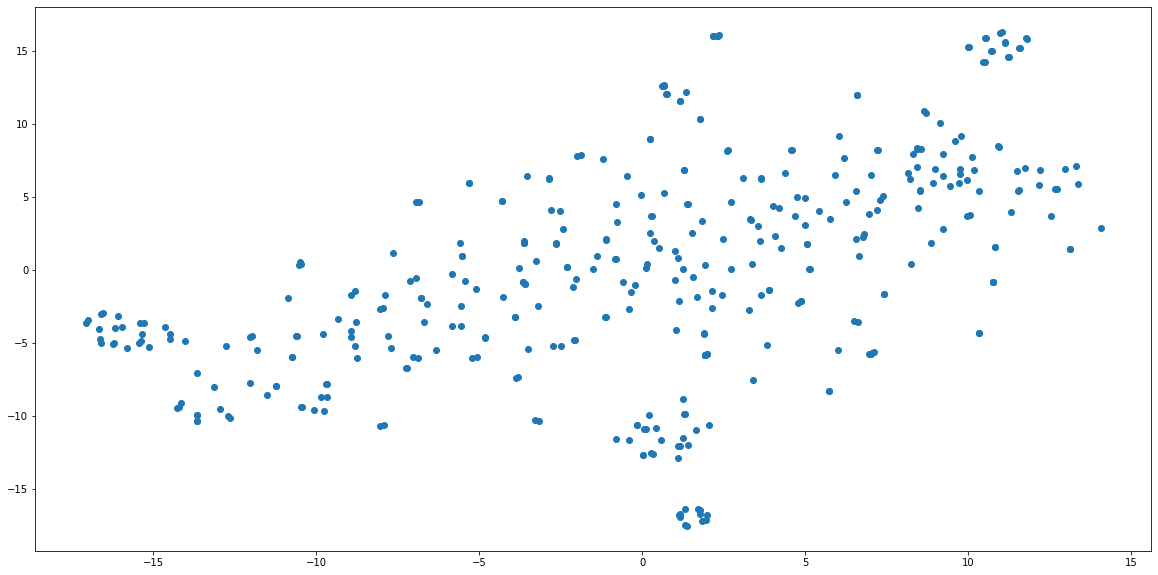

In [20]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

plt.show()

#### 군집개수 결정 - 엘보우 함수

In [21]:
# 엘보우 함수

def elbow(X):
    
    sse = []
    
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

엘보우: 100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


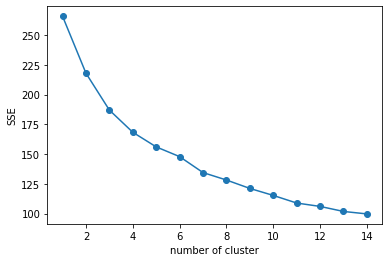

In [22]:
word_vectors = covid.문장벡터.to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

#### 군집 개수 결정 - 실루엣 계수

In [23]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()


#### 군집 수 = 2일 때 

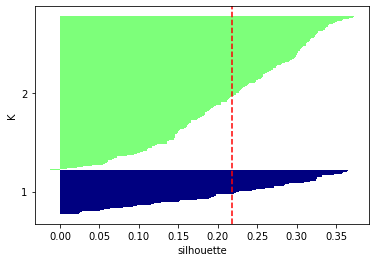

In [24]:
word_vectors = covid.문장벡터.to_list()
k= 2

km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집 수 = 3일 때

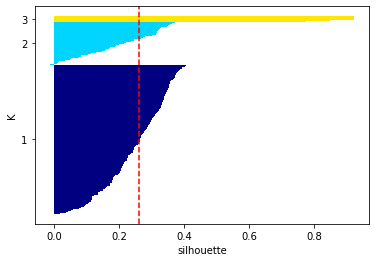

In [25]:
word_vectors = covid.문장벡터.to_list()
k= 3

km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집 수 = 4일 때

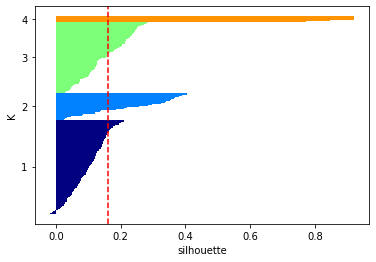

In [26]:
word_vectors = covid.문장벡터.to_list()
k= 4

km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집 수 = 5일 때

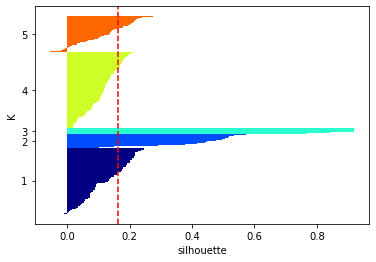

In [27]:
word_vectors = covid.문장벡터.to_list()
k= 5

km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

#### 군집 수 = 6일 때

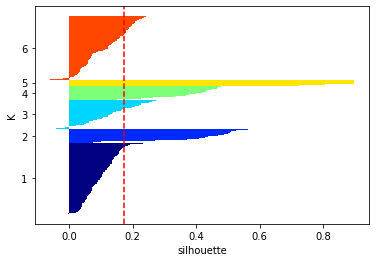

In [37]:
word_vectors = covid.문장벡터.to_list()
k= 6

km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## 4. Kmeans 수행 및 시각화

#### 군집 수 = 3일 때


In [68]:
# K means 수행 

word_vectors = covid.문장벡터.to_list()
num_clusters = 3

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
covid['category'] = idx

In [69]:
covid.category.value_counts()

2    290
0     87
1     12
Name: category, dtype: int64

In [70]:
covid.to_csv('[코로나] 3cluster.csv', encoding='utf-8-sig')

In [71]:
from sklearn.manifold import TSNE

X = covid['문장벡터'].to_list()
y = covid['category'].to_list()

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = covid['의안번호'].to_list()
tsne_df['BillName'] = covid['의안명'].to_list()
tsne_df['cluster_no'] = y


In [72]:
tsne_df.head()

,x_coord,y_coord,BillNo,BillName,cluster_no
0,-6.049650,-27.586233,2024549,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
1,4.367957,-21.910419,2024556,검역법 일부개정법률안,2
2,-2.415426,-24.778215,2024555,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
3,-5.064430,-18.792486,2024582,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
4,-9.230567,-24.523901,2024584,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2


In [73]:
tsne_df.to_csv("[코로나] tnse_3clusters.csv", encoding="utf-8-sig")

In [74]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [75]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]

colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}

colors = [colormap[x] for x in tsne_df['cluster_no']]

tsne_df['color'] = colors

In [76]:
# Bokeh가 인식하는 DataSource 객체 만들어주기

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)

tsne_plot = figure(
    title='Bills about Covid19',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [77]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)

#### 군집 수 = 4일 때

In [85]:
# K means 수행 

word_vectors = covid.문장벡터.to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
covid['category'] = idx

In [86]:
covid.category.value_counts()

1    165
2    143
0     69
3     12
Name: category, dtype: int64

In [87]:
covid.to_csv('[코로나] 4cluster.csv', encoding='utf-8-sig')

In [88]:
from sklearn.manifold import TSNE

X = covid['문장벡터'].to_list()
y = covid['category'].to_list()

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = covid['의안번호'].to_list()
tsne_df['BillName'] = covid['의안명'].to_list()
tsne_df['cluster_no'] = y

In [89]:
tsne_df.head()

,x_coord,y_coord,BillNo,BillName,cluster_no
0,-6.049650,-27.586233,2024549,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
1,4.367957,-21.910419,2024556,검역법 일부개정법률안,2
2,-2.415426,-24.778215,2024555,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
3,-5.064430,-18.792486,2024582,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2
4,-9.230567,-24.523901,2024584,감염병의 예방 및 관리에 관한 법률 일부개정법률안,2


In [90]:
tsne_df.to_csv("[코로나] tsne_4clusters.csv", encoding="utf-8-sig")

In [91]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [92]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]

colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}

colors = [colormap[x] for x in tsne_df['cluster_no']]

tsne_df['color'] = colors

In [93]:
# Bokeh가 인식하는 DataSource 객체 만들어주기

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)

tsne_plot = figure(
    title='Bills about Covid19',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [94]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)

#### 군집 수 = 11일 때

In [107]:
# K means 수행 

word_vectors = covid.문장벡터.to_list()
num_clusters = 11

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
covid['category'] = idx

In [108]:
covid.category.value_counts()

1     97
0     87
6     62
10    28
5     27
2     26
7     18
9     14
4     12
3     12
8      6
Name: category, dtype: int64

In [109]:
from sklearn.manifold import TSNE

X = covid['문장벡터'].to_list()
y = covid['category'].to_list()

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = covid['의안번호'].to_list()
tsne_df['BillName'] = covid['의안명'].to_list()
tsne_df['cluster_no'] = y

In [110]:
tsne_df.head()

,x_coord,y_coord,BillNo,BillName,cluster_no
0,-6.049650,-27.586233,2024549,감염병의 예방 및 관리에 관한 법률 일부개정법률안,0
1,4.367957,-21.910419,2024556,검역법 일부개정법률안,0
2,-2.415426,-24.778215,2024555,감염병의 예방 및 관리에 관한 법률 일부개정법률안,0
3,-5.064430,-18.792486,2024582,감염병의 예방 및 관리에 관한 법률 일부개정법률안,0
4,-9.230567,-24.523901,2024584,감염병의 예방 및 관리에 관한 법률 일부개정법률안,0


In [111]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [112]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]

colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}

colors = [colormap[x] for x in tsne_df['cluster_no']]

tsne_df['color'] = colors

In [113]:
# Bokeh가 인식하는 DataSource 객체 만들어주기

plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)

tsne_plot = figure(
    title='Bills about Covid19',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [114]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)